In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
pd.options.display.max_columns = None
from utils import create_time_series_splits
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('../data/datasets_2023-2025_beta.parquet')
df.timestamp = pd.to_datetime(df.timestamp, unit = 's')

In [12]:
usd_coins = ["DAIUSD_720.parquet", "USDCUSD_720.parquet", "USDTUSD_720.parquet", "USTUSD_720.parquet"]
currencies = ["AUDUSD_720.parquet", "EURUSD_720.parquet", "GBPUSD_720.parquet"]
commodities = ['PAXGUSD_720.parquet']

df = df[~df.filename.isin(usd_coins + currencies + commodities)]
df['log_return'] = df.groupby('filename')['close'].transform(lambda x: np.log(x / x.shift(1)))
df['next_return'] = df.groupby('filename')['log_return'].shift(-1)
df = df[df['log_return'].notna()]
df = df[df['next_return'].notna()]

df['filename_id'] = df['filename'].astype('category').cat.codes
# OHE filename
# ohe = OneHotEncoder(sparse_output=False)
# ohe.fit(df[['filename']])
# encoded_filenames = ohe.transform(df[['filename']])
# encoded_filenames_df = pd.DataFrame(encoded_filenames, columns=ohe.get_feature_names_out(['filename']))
# df = pd.concat([df.reset_index(drop=True), encoded_filenames_df.reset_index(drop=True)], axis=1)

### One model across all names

In [15]:
train_dfs, test_dfs = create_time_series_splits(df, date_column='timestamp', months_train=12, months_test=0.25)

all_preds = []
feature_importances = []

for train_df, test_df in zip(train_dfs, test_dfs):
    X_train = train_df.drop(columns=['next_return', 'timestamp', 'filename'])
    y_train = train_df['next_return']
    X_test = test_df.drop(columns=['next_return', 'timestamp', 'filename'])
    y_test = test_df['next_return']
    
    model = RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
    )

    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    test_df['pred'] = preds
    all_preds.append(test_df[['timestamp', 'filename', 'pred', 'next_return']])
    feature_importances.append(model.feature_importances_)
all_preds_df = pd.concat(all_preds, ignore_index=True)
# all_preds_df.to_parquet('RF_predictions_one_model.parquet', index=False)

In [5]:
all_preds_df.groupby('filename').apply(lambda x: r2_score(x['next_return'], x['pred'])).sort_values(ascending=False)

filename
YFIUSD_720.parquet      0.016279
ZECUSD_720.parquet      0.013485
DASHUSD_720.parquet     0.013187
SHIBUSD_720.parquet     0.013027
COMPUSD_720.parquet     0.011569
                          ...   
RPLUSD_720.parquet     -0.015316
JASMYUSD_720.parquet   -0.018639
JUNOUSD_720.parquet    -0.020209
CQTUSD_720.parquet     -0.067377
KSMUSD_720.parquet     -0.081911
Length: 96, dtype: float64

In [16]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0269, MSE: 0.0017, R2: -0.0053, RMSE: 0.0416


In [17]:
# Feature importances
feature_importances_df = pd.DataFrame(feature_importances, columns=X_train.columns)
feature_importances_df.mean().sort_values(ascending=False)

mom_2_1                0.142760
price_ema_diff_14      0.135882
ltrev_28               0.113265
close_to_high          0.063518
strev_6                0.048054
mom_14_2               0.042301
log_price_range        0.039155
ma_zscore_14           0.038590
return                 0.029068
log_return             0.028590
close_to_low           0.027778
sto_osc_14             0.027674
ema_diff_norm_10_21    0.027501
realized_vol_14        0.025702
rsi                    0.025133
mom_12_7               0.022900
weighted_vol_14        0.021398
mom_36_13              0.018914
beta_market            0.018020
ema_diff_norm_20_50    0.016318
volume                 0.012724
volume_change          0.009988
macd_hist              0.009079
volume_zscore_14       0.007968
low                    0.007699
vwap_14                0.006898
trades                 0.006727
high                   0.006394
close                  0.006367
amihud_14              0.006218
open                   0.005809
filename

In [7]:
all_preds_df.groupby('filename').apply(lambda x: r2_score(x['next_return'], x['pred'])).sort_values(ascending=False)

filename
SHIBUSD_720.parquet     0.030273
JUNOUSD_720.parquet     0.026625
YFIUSD_720.parquet      0.020002
ATLASUSD_720.parquet    0.019264
EGLDUSD_720.parquet     0.018168
                          ...   
PHAUSD_720.parquet     -0.016166
RPLUSD_720.parquet     -0.019065
JASMYUSD_720.parquet   -0.024083
CQTUSD_720.parquet     -0.076304
KSMUSD_720.parquet     -0.084885
Length: 96, dtype: float64

In [8]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0269, MSE: 0.0017, R2: -0.0041, RMSE: 0.0416


In [24]:
# MAE: 0.0182, MSE: 0.0008, R2: -0.0196, RMSE: 0.0291

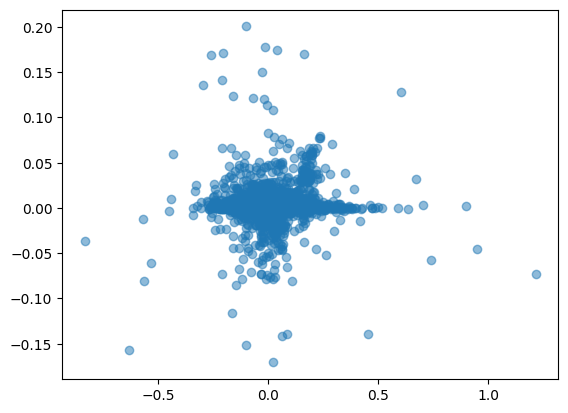

In [9]:
plt.scatter(all_preds_df['next_return'], all_preds_df['pred'], alpha=0.5)

In [10]:
# model.feature_importances_ 
pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

,feature,importance
21,price_ema_diff_14,0.157182
13,mom_2_1,0.113580
18,ltrev_28,0.096898
27,sto_osc_14,0.051774
11,log_price_range,0.050429
30,beta_market,0.046526
17,strev_6,0.045604
20,ema_diff_norm_20_50,0.045573
24,weighted_vol_14,0.045120
12,ma_zscore_14,0.040590


### One model for each name

In [7]:
all_preds = []

for file in df.filename.unique():
    cur_df = df[df['filename'] == file]
    if (cur_df.timestamp.max() - cur_df.timestamp.min()).days / 365 < 1.5:
        print(f"Skipping {file} - less than 1.5 years")
        continue
    print(f"Processing {file} -- {round((cur_df.timestamp.max() - cur_df.timestamp.min()).days / 365, 2)} years of data")
    train_dfs, test_dfs = create_time_series_splits(cur_df, 12, 1, date_column='timestamp')

    for train_df, test_df in zip(train_dfs, test_dfs):
        X_train = train_df.drop(columns=['next_return', 'timestamp', 'filename'])
        y_train = train_df['next_return']
        X_test = test_df.drop(columns=['next_return', 'timestamp', 'filename'])
        y_test = test_df['next_return']
        
        model = RandomForestRegressor(
                n_estimators=100, 
                random_state=42, 
                n_jobs=-1,
                max_depth=5,
                min_samples_split=5,
                min_samples_leaf=2,
        )

        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        test_df['pred'] = preds
        all_preds.append(test_df[['timestamp', 'filename', 'pred', 'next_return']])

all_preds_df = pd.concat(all_preds, ignore_index=True)
all_preds_df.to_parquet('RF_predictions_ind_models.parquet', index=False)

Processing 1INCHUSD_720.parquet -- 2.0 years of data
Processing AAVEUSD_720.parquet -- 2.0 years of data
Processing ACHUSD_720.parquet -- 2.0 years of data
Processing ADAUSD_720.parquet -- 2.0 years of data
Processing AKTUSD_720.parquet -- 2.0 years of data
Processing ALGOUSD_720.parquet -- 2.0 years of data
Processing ANKRUSD_720.parquet -- 2.0 years of data
Processing APEUSD_720.parquet -- 2.0 years of data
Processing APTUSD_720.parquet -- 2.0 years of data
Processing ASTRUSD_720.parquet -- 2.0 years of data
Processing ATLASUSD_720.parquet -- 2.0 years of data
Processing ATOMUSD_720.parquet -- 2.0 years of data
Processing AVAXUSD_720.parquet -- 2.0 years of data
Processing AXSUSD_720.parquet -- 2.0 years of data
Processing BATUSD_720.parquet -- 2.0 years of data
Processing BCHUSD_720.parquet -- 2.0 years of data
Processing BLZUSD_720.parquet -- 2.0 years of data
Processing BSXUSD_720.parquet -- 2.0 years of data
Processing BTTUSD_720.parquet -- 2.0 years of data
Processing CFGUSD_720

In [8]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0270, MSE: 0.0018, R2: -0.1391, RMSE: 0.0423


In [9]:
all_preds_df

,timestamp,filename,pred,next_return
0,2024-01-02 00:00:00,1INCHUSD_720.parquet,0.003538,-0.016737
1,2024-01-02 12:00:00,1INCHUSD_720.parquet,0.001863,-0.029981
2,2024-01-03 00:00:00,1INCHUSD_720.parquet,0.004116,-0.079137
3,2024-01-03 12:00:00,1INCHUSD_720.parquet,0.012157,0.083476
4,2024-01-04 00:00:00,1INCHUSD_720.parquet,0.003986,-0.008696
...,...,...,...,...
64315,2024-11-29 12:00:00,ZECUSD_720.parquet,-0.002486,0.017107
64316,2024-11-30 00:00:00,ZECUSD_720.parquet,-0.001759,0.068343
64317,2024-11-30 12:00:00,ZECUSD_720.parquet,-0.002374,-0.024739
64318,2024-12-01 00:00:00,ZECUSD_720.parquet,-0.000009,0.039792


### Old

In [17]:
in_folder_path = "../data/Kraken_features/"

all_res_df = pd.DataFrame({"timestamp": pd.date_range(start="2020-01-01", end="2026-01-01", freq="360min")})
all_res_df.set_index("timestamp", inplace=True)

ctr = 0
for file in os.listdir(in_folder_path):
    df = pd.read_parquet(in_folder_path + file)
    if len(df) < 4 * 365 * 1.5:
        print(f"Skipping {file} - less than 1.5 years")
        continue
    else:
        print(f"Processing {file} -- {round((df.index.max() - df.index.min()).days / 365, 2)} years of data")
    train_dfs, test_dfs = create_time_series_splits(df, 6, 1)

    all_preds = []
    all_targets = []
    all_times = []
    for train_df, test_df in zip(train_dfs, test_dfs):
        X_train = train_df.drop(columns = ['date'])[:-1]
        y_train = train_df['log_return'][1:]

        X_test = test_df.drop(columns = ['date'])[:-1]
        y_test = test_df['log_return'][1:]

        model = RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
        )
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        
        all_preds.extend(preds)
        all_targets.extend(y_test)
        all_times.extend(test_df.index[1:])

    sym = file.split(".")[0]
    col_pred = f"pred_{sym}"
    col_target = f"target_{sym}"

    if col_pred not in all_res_df.columns:
        all_res_df[col_pred] = np.nan
    if col_target not in all_res_df.columns:
        all_res_df[col_target] = np.nan

    all_res_df.loc[all_times, col_pred] = all_preds
    all_res_df.loc[all_times, col_target] = all_targets
    
    if ctr == 5:
        break
    ctr += 1

Processing SPELLUSD_720.parquet -- 2.92 years of data
Processing AIRUSD_720.parquet -- 3.06 years of data
Processing SUIUSD_720.parquet -- 1.83 years of data
Processing DOTUSD_720.parquet -- 3.22 years of data
Processing CVXUSD_720.parquet -- 2.92 years of data
Processing WOOUSD_720.parquet -- 3.0 years of data
